# 3. Model Inference (PKL) - Bicep Curl

**Objective:**
1. Load a specific trained model (e.g., RandomForest from PKL) and its corresponding scaler.
2. Load the raw test dataset.
3. Preprocess the test data using the same feature extraction and scaling logic.
4. Perform inference on the test data.
5. Evaluate the model's performance with detailed metrics and visualizations.

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Add utils directory to sys.path
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.geometry_utils import GeometryUtils
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

# Configure visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 10

## 3.1 Define Paths and Constants

In [2]:
BASE_DATA_PATH = "../data/"
TEST_RAW_PATH = os.path.join(BASE_DATA_PATH, "test.csv")

MODEL_PKL_DIR = "../models/pkl/"
VISIBILITY_THRESHOLD = 0.7

# CHOOSE WHICH ARM'S MODEL TO TEST (e.g., 'left' or 'right')
ARM_TO_TEST = "right" # or "right"
# CHOOSE WHICH MODEL TYPE TO LOAD (e.g., 'RF', or the name of another model if saved)
MODEL_TYPE_TO_LOAD = "NB" # e.g., RF_model_left.pkl

SCALER_PATH = os.path.join(MODEL_PKL_DIR, f"scaler_{ARM_TO_TEST.lower()}.pkl")
MODEL_PATH = os.path.join(MODEL_PKL_DIR, f"{MODEL_TYPE_TO_LOAD}_model_{ARM_TO_TEST.lower()}.pkl")

print(f"Testing with: {ARM_TO_TEST.capitalize()} Arm, Model: {MODEL_TYPE_TO_LOAD}")
print(f"Scaler path: {SCALER_PATH}")
print(f"Model path: {MODEL_PATH}")

Testing with: Right Arm, Model: NB
Scaler path: ../models/pkl/scaler_right.pkl
Model path: ../models/pkl/NB_model_right.pkl


## 3.2 Feature Extraction Function (Same as in Training)

In [3]:
def extract_arm_features_from_df(df_raw, geometry_util, arm_side):
    """Processes a raw DataFrame and extracts features for a specific arm."""
    processed_data = []

    for index, row in df_raw.iterrows():
        label_original = row["label"]
        label_numeric = 1 if label_original == "C" else (0 if label_original == "L" else -1) # -1 for unknown
        if label_numeric == -1: continue
            
        if arm_side == "left":
            sh_x, sh_y, sh_v = row.get("left_shoulder_x", np.nan), row.get("left_shoulder_y", np.nan), row.get("left_shoulder_v", 0)
            el_x, el_y, el_v = row.get("left_elbow_x", np.nan), row.get("left_elbow_y", np.nan), row.get("left_elbow_v", 0)
            wr_x, wr_y, wr_v = row.get("left_wrist_x", np.nan), row.get("left_wrist_y", np.nan), row.get("left_wrist_v", 0)
            hip_x, hip_y, hip_v = row.get("left_hip_x", np.nan), row.get("left_hip_y", np.nan), row.get("left_hip_v", 0)
        elif arm_side == "right":
            sh_x, sh_y, sh_v = row.get("right_shoulder_x", np.nan), row.get("right_shoulder_y", np.nan), row.get("right_shoulder_v", 0)
            el_x, el_y, el_v = row.get("right_elbow_x", np.nan), row.get("right_elbow_y", np.nan), row.get("right_elbow_v", 0)
            wr_x, wr_y, wr_v = row.get("right_wrist_x", np.nan), row.get("right_wrist_y", np.nan), row.get("right_wrist_v", 0)
            hip_x, hip_y, hip_v = row.get("right_hip_x", np.nan), row.get("right_hip_y", np.nan), row.get("right_hip_v", 0)
        else:
            continue

        if all(v > VISIBILITY_THRESHOLD for v in [sh_v, el_v, wr_v, hip_v]):
            if not any(np.isnan([sh_x, sh_y, el_x, el_y, wr_x, wr_y, hip_x, hip_y])):
                shoulder = [sh_x, sh_y]
                elbow = [el_x, el_y]
                wrist = [wr_x, wr_y]
                hip = [hip_x, hip_y]
                
                elbow_angle = geometry_util.calculate_angle(shoulder, elbow, wrist)
                shoulder_angle = geometry_util.calculate_angle(elbow, shoulder, hip)
                
                if not (np.isnan(elbow_angle) or np.isnan(shoulder_angle)):
                    processed_data.append({
                        "label": label_numeric,
                        "elbow_angle": elbow_angle,
                        "shoulder_angle": shoulder_angle
                    })
    return pd.DataFrame(processed_data)

## 3.3 Load Model, Scaler, and Test Data

In [4]:
model = None
scaler = None
df_test_processed = pd.DataFrame()
geo_utils = GeometryUtils()

try:
    with open(MODEL_PATH, "rb") as f:
        model = pickle.load(f)
    print(f"Model loaded successfully from {MODEL_PATH}")
    print(f"Model type: {type(model)}")
    if hasattr(model, 'steps'): # If it's a pipeline
        print(f"Final estimator in pipeline: {type(model.steps[-1][1])}")

    with open(SCALER_PATH, "rb") as f:
        scaler = pickle.load(f)
    print(f"Scaler loaded successfully from {SCALER_PATH}")

    df_raw_test = pd.read_csv(TEST_RAW_PATH)
    print(f"Raw test data loaded. Shape: {df_raw_test.shape}")

    # Process test data for the chosen arm
    df_test_processed = extract_arm_features_from_df(df_raw_test, geo_utils, ARM_TO_TEST.lower())
    print(f"Processed test data for {ARM_TO_TEST} arm. Shape: {df_test_processed.shape}")

except FileNotFoundError as e:
    print(f"Error: {e}. Check paths for model, scaler, or test data.")
except Exception as e:
    print(f"An error occurred: {e}")

if df_test_processed.empty:
    print(f"Warning: Processed test data for {ARM_TO_TEST} arm is empty. Cannot proceed with inference.")

Model loaded successfully from ../models/pkl/NB_model_right.pkl
Model type: <class 'sklearn.naive_bayes.GaussianNB'>
Scaler loaded successfully from ../models/pkl/scaler_right.pkl
Raw test data loaded. Shape: (604, 37)
Processed test data for right arm. Shape: (308, 3)


## 3.4 Prepare Data for Inference and Predict

In [5]:
y_true = None
y_pred = None
y_pred_proba = None # For ROC/PR curves

if model and scaler and not df_test_processed.empty and 'label' in df_test_processed.columns:
    if len(df_test_processed['label'].unique()) < 2:
        print(f"Warning: Processed test data for {ARM_TO_TEST} arm has only one class. Evaluation might be misleading.")
        
    X_test = df_test_processed.drop("label", axis=1)
    y_true = df_test_processed["label"]
    
    if X_test.empty:
        print("Feature set X_test is empty after dropping label. Cannot proceed.")
    else:
        try:
            X_test_scaled = scaler.transform(X_test)
            print(f"Test data scaled. Shape: {X_test_scaled.shape}")
            
            y_pred = model.predict(X_test_scaled)
            print("Predictions made successfully.")
            
            if hasattr(model, "predict_proba"):
                y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] # Probability of positive class (1)
            else:
                print("Model does not support predict_proba. ROC/PR curves will not be generated.")
                
        except ValueError as ve:
            print(f"ValueError during scaling or prediction: {ve}")
            print("This might be due to a mismatch in the number of features expected by the scaler/model.")
            print(f"  Features in X_test: {X_test.columns.tolist()}")
            if hasattr(scaler, 'n_features_in_'): print(f"  Scaler expected features: {scaler.n_features_in_}")
            # For pipeline, check final estimator
            final_estimator = model.steps[-1][1] if hasattr(model, 'steps') else model
            if hasattr(final_estimator, 'n_features_in_'): print(f"  Model expected features: {final_estimator.n_features_in_}")
            
        except Exception as e:
            print(f"Error during prediction: {e}")
else:
    print("Model, scaler, or processed test data not available/valid. Skipping prediction.")

Test data scaled. Shape: (308, 2)
Predictions made successfully.


## 3.5 Evaluate Performance


--- Performance Evaluation for Right Arm (NB Model) ---
Accuracy: 0.8214

Classification Report:
                   precision    recall  f1-score   support

L (Incorrect/Low)       0.71      0.98      0.83       133
      C (Correct)       0.98      0.70      0.82       175

         accuracy                           0.82       308
        macro avg       0.85      0.84      0.82       308
     weighted avg       0.86      0.82      0.82       308


Confusion Matrix:


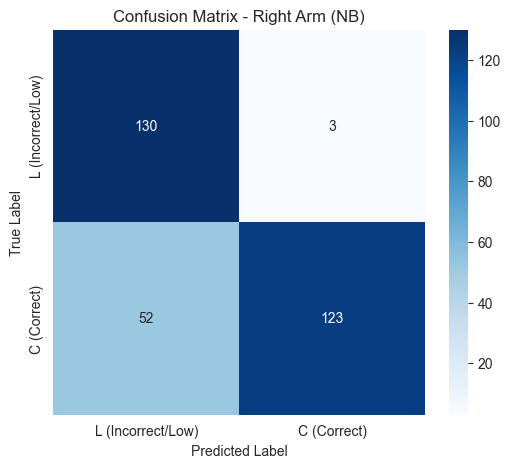

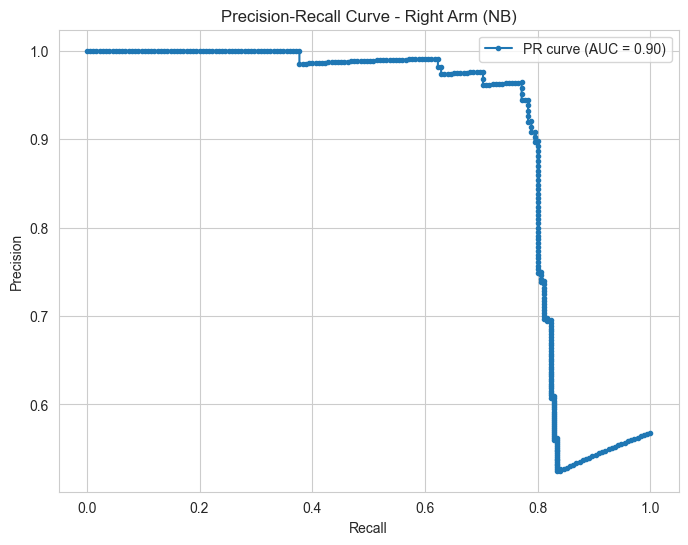

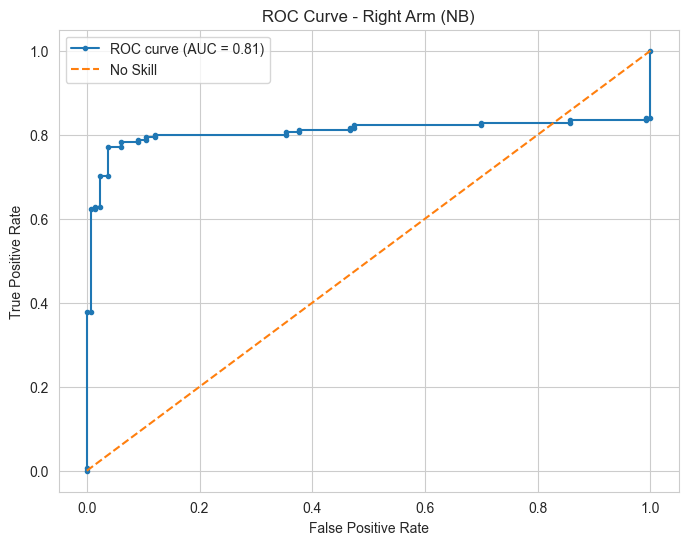

In [6]:
if y_true is not None and y_pred is not None:
    print(f"\n--- Performance Evaluation for {ARM_TO_TEST.capitalize()} Arm ({MODEL_TYPE_TO_LOAD} Model) ---")
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    print("\nClassification Report:")
    # Ensure target names match the numeric labels (0 and 1)
    # L (Incorrect) was mapped to 0, C (Correct) to 1
    target_names = ['L (Incorrect/Low)', 'C (Correct)']
    try:
        print(classification_report(y_true, y_pred, target_names=target_names, labels=[0,1], zero_division=0))
    except ValueError as e:
        print(f"Error generating classification report (possibly due to only one class in y_true or y_pred): {e}")
        print(f"Unique y_true: {np.unique(y_true)}")
        print(f"Unique y_pred: {np.unique(y_pred)}")
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {ARM_TO_TEST.capitalize()} Arm ({MODEL_TYPE_TO_LOAD})')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    # Precision-Recall Curve (if probabilities are available)
    if y_pred_proba is not None:
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        pr_auc = auc(recall, precision)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, marker='.', label=f'PR curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {ARM_TO_TEST.capitalize()} Arm ({MODEL_TYPE_TO_LOAD})')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # ROC Curve (if probabilities are available)
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, marker='.', label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {ARM_TO_TEST.capitalize()} Arm ({MODEL_TYPE_TO_LOAD})')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("Cannot evaluate performance. y_true or y_pred is not available.")

## 3.6 Analysis of Misclassifications (Optional)


--- Analysis of Misclassified Samples (55 total) ---
Showing first 5 misclassified samples:


,elbow_angle,shoulder_angle,true_label,predicted_label
130,53.314952,12.197928,0,1
149,38.945751,18.195691,1,0
150,35.968463,17.150722,1,0
151,34.505956,16.750911,1,0
152,32.802712,16.487997,1,0


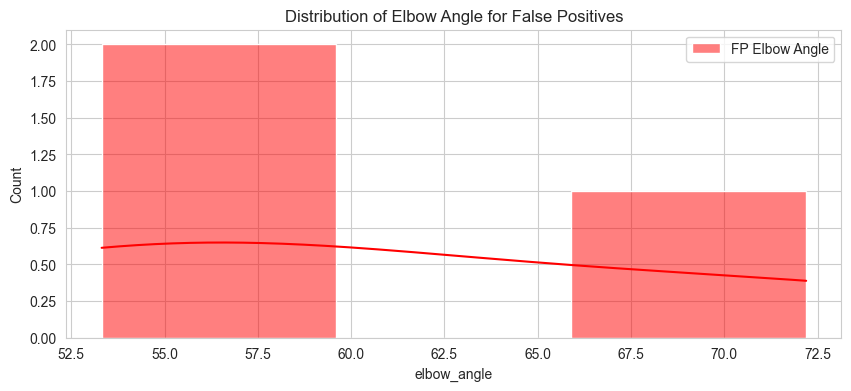

,count,mean,std,min,25%,50%,75%,max
elbow_angle,3.0,60.898811,9.972516,53.314952,55.250684,57.186415,64.690740,72.195065
shoulder_angle,3.0,9.525507,4.567771,4.251256,8.189296,12.127336,12.162632,12.197928


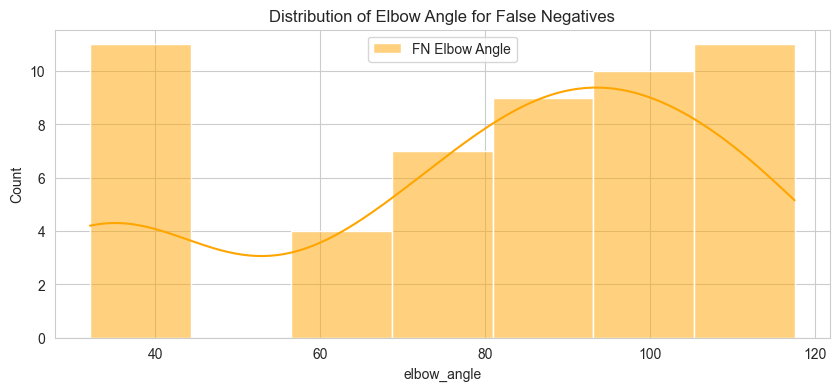

,count,mean,std,min,25%,50%,75%,max
elbow_angle,52.0,80.124045,27.822113,32.088828,65.609126,87.516660,98.684932,117.479877
shoulder_angle,52.0,69.690412,39.154552,15.869461,23.373127,79.443075,108.167261,113.371275


In [7]:
if y_true is not None and y_pred is not None and not X_test.empty:
    # Create a DataFrame with true labels, predictions, and features
    misclassified_df = X_test.copy()
    misclassified_df['true_label'] = y_true
    misclassified_df['predicted_label'] = y_pred
    
    misclassified_samples = misclassified_df[misclassified_df['true_label'] != misclassified_df['predicted_label']]
    
    if not misclassified_samples.empty:
        print(f"\n--- Analysis of Misclassified Samples ({len(misclassified_samples)} total) ---")
        print("Showing first 5 misclassified samples:")
        display(misclassified_samples.head())
        
        # Example: Compare distributions of features for correctly vs. incorrectly classified samples
        # This can give clues about why certain samples are hard to classify.
        # For simplicity, let's look at 'elbow_angle' for False Positives and False Negatives.
        
        false_positives = misclassified_samples[(misclassified_samples['true_label'] == 0) & (misclassified_samples['predicted_label'] == 1)]
        false_negatives = misclassified_samples[(misclassified_samples['true_label'] == 1) & (misclassified_samples['predicted_label'] == 0)]
        
        if not false_positives.empty:
            plt.figure(figsize=(10, 4))
            sns.histplot(false_positives['elbow_angle'], color='red', label='FP Elbow Angle', kde=True)
            plt.title('Distribution of Elbow Angle for False Positives')
            plt.legend()
            plt.show()
            display(false_positives[['elbow_angle', 'shoulder_angle']].describe().T)
            
        if not false_negatives.empty:
            plt.figure(figsize=(10, 4))
            sns.histplot(false_negatives['elbow_angle'], color='orange', label='FN Elbow Angle', kde=True)
            plt.title('Distribution of Elbow Angle for False Negatives')
            plt.legend()
            plt.show()
            display(false_negatives[['elbow_angle', 'shoulder_angle']].describe().T)
    else:
        print("No misclassified samples found. Perfect prediction on this test set slice!")